## 5A. Práctica: Clasificador
### Nombre: **Luis Fernando Izquierdo Berdugo**
### Materia: **Procesamiento de Información**
### Fecha: **12 de Noviembre de 2024**


El ejercicio propuesto es clasificar información sobre comentarios de twitter que hablan de celulares.

Se proporciona un dataset de entrenamiento que cuenta con cuatro clases , campo "klass" (information, positive, negative y neutral). Los comentarios fueron etiquetados de manera manual por personas y se asume ese conocimiento como verdadero.

Los datos están en formato json que contiene un diccionario por cada tweet. El diccionario contiene los campos que servirán para entrenar, dos ejemplos del contenido son::

`{"categories": "[ \"DEVICE\", \"OS\" ]", "id": "d0fb202ea47c3cad448ea4e5e31bd404", "klass": "information", "text": "RT @matukpuntocom: Xperia Play se quedar\u00e1 sin Android 4.0 http://t.co/463lAcCp", "type": "Xperia"}`

`{"categories": "[ \"MOBILE\" ]", "id": "d76f590d27f8eb415696e945f16b7e1c", "klass": "neutral", "text": "RT @AlbertoCiurana: Hay gente que se desconecta del mundo suicid\u00e1ndose. Yo solo apago el celular.", "type": "Celular"}`

Los diccionarios contienen los campos:
- categories
- id
- klass
- text
- type


Van a usar el campo text para entrenar y la etiqueta será el campo klass.

Entregar un notebook donde:
1. Se lean los archivos de datos y crear el conjunto de entrenamiento y prueba.
2. Se pre procese el texto
3. Crear gráficas que muestren las palabras más comunes para cada una de las etiquetas.
4. Vectorizar el texto.
5. Entrenar un clasificador para predecir la etiqueta del texto.
6. Calcular el accuracy.
7. Al final del notebook incluir un texto donde se documente los diferentes tipos de pre procesamiento que usaron, el tipo de vectorizador, el modelo para clasificar y su accuracy.

Prueben varias combinaciones de pre-procesamiento, vectorizado y modelo de aprendizaje para obtener el mayor accuracy en el conjunto de prueba.

## Lectura de los archivos de datos

In [29]:
import pandas as pd
from io import StringIO

def read_json_lines(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(pd.read_json(StringIO(line), lines=True))
    return pd.concat(data, ignore_index=True)

train_data = read_json_lines('cellphones_train.json')
test_data = read_json_lines('cellphones_test.json')

## Crear conjuntos de entrenamiento y pruebas

In [30]:
from sklearn.model_selection import train_test_split

X_train = train_data['text']
y_train = train_data['klass']
X_test = test_data['text']
y_test = test_data['klass']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1004)

## Preprocesamiento del texto

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import unicodedata
import re

#Se descargan los recursos de nltk necesarios
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt_tab')

#Se inicializa el lemmatizer
lemmatizer = nltk.WordNetLemmatizer()

# Definir función de preprocesamiento
def preprocess_text(text):
    # Normalización de texto para eliminar acentos
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s@]', '', text)
    # Tokenizar el texto
    tokens = word_tokenize(text)
    # Eliminar stopwords, signos de puntuación y números y aplicar lemmatización
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stopwords.words('spanish')]
    # Unir tokens en una sola cadena
    return ' '.join(tokens)

In [32]:
# Convertir todos los valores a cadenas
X_train = X_train.astype(str)
X_val = X_val.astype(str)
X_test = X_test.astype(str)

# Aplicar preprocesamiento a los conjuntos de entrenamiento y prueba
X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

## Gráficas de palabras más comunes

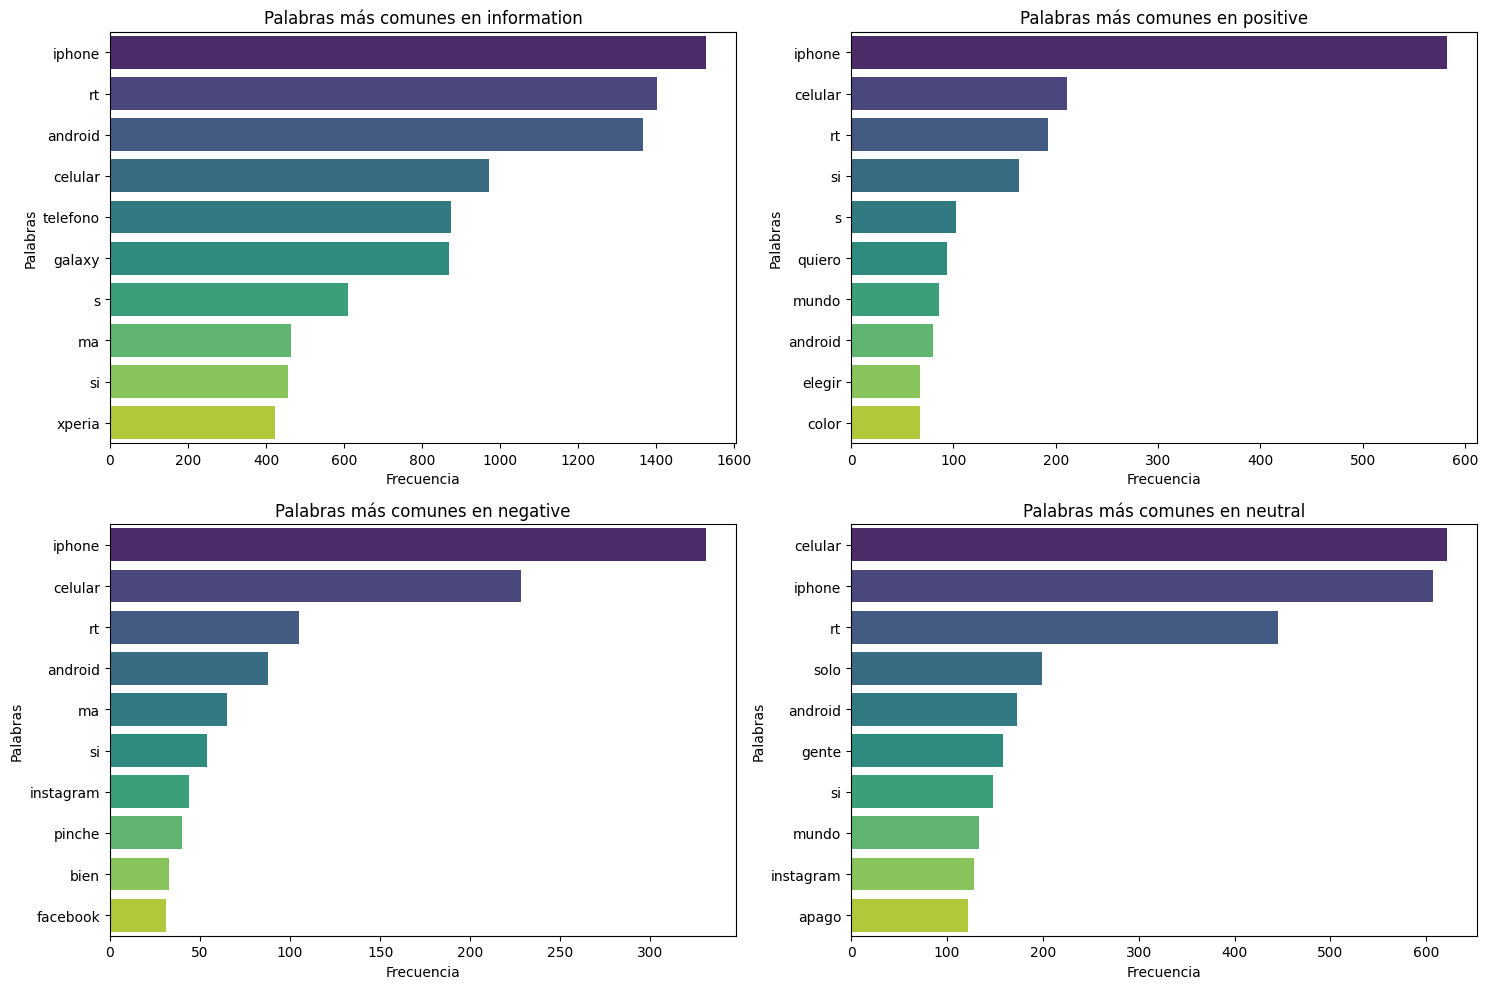

In [33]:
import collections
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un diccionario para almacenar las palabras más comunes por cada etiqueta
common_words = {'information': collections.Counter(), 'positive': collections.Counter(), 'negative': collections.Counter(), 'neutral': collections.Counter()}

# Contar las palabras más comunes para cada etiqueta
for text, label in zip(X_train, y_train):
    common_words[label].update(text.split())

# Crear un DataFrame para facilitar la visualización
common_words_df = pd.DataFrame({label: [word for word, _ in common_words[label].most_common(10)] for label in common_words})
common_counts_df = pd.DataFrame({label: [count for _, count in common_words[label].most_common(10)] for label in common_words})

# Configurar el tamaño de las figuras
plt.figure(figsize=(15, 10))

# Crear subplots para cada etiqueta
for i, label in enumerate(common_words.keys(), 1):
    plt.subplot(2, 2, i)
    sns.barplot(x=common_counts_df[label], y=common_words_df[label], hue=common_words_df[label], palette='viridis', dodge=False, legend=False)
    plt.title(f'Palabras más comunes en {label}')
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabras')

# Ajustar el layout
plt.tight_layout()
plt.show()

## Vectorización del texto

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Vectorizar el texto usando CountVectorizer
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)
X_val_count = count_vectorizer.transform(X_val)
X_test_count = count_vectorizer.transform(X_test)

# Mostrar la forma de las matrices resultantes
print(f'Forma de X_train_count: {X_train_count.shape}')
print(f'Forma de X_val_count: {X_val_count.shape}')
print(f'Forma de X_test_count: {X_test_count.shape}')

# Vectorizar el texto usando TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Mostrar la forma de las matrices resultantes
print(f'Forma de X_train_tfidf: {X_train_tfidf.shape}')
print(f'Forma de X_val_tfidf: {X_val_tfidf.shape}')
print(f'Forma de X_test_tfidf: {X_test_tfidf.shape}')

Forma de X_train_count: (9155, 16573)
Forma de X_val_count: (2289, 16573)
Forma de X_test_count: (4905, 16573)
Forma de X_train_tfidf: (9155, 16573)
Forma de X_val_tfidf: (2289, 16573)
Forma de X_test_tfidf: (4905, 16573)


## Entrenar Clasificador

In [69]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Definir una función para entrenar un clasificador
def train_classifier(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    return model, val_accuracy

# Inicializar los modelos
logistic_regression = LogisticRegression(max_iter=1000, solver='saga')
svm = SVC(C=1000, kernel='rbf', gamma='scale')
naive_bayes = MultinomialNB(alpha=0.1)
random_forest = RandomForestClassifier()

# Entrenar los modelos con CountVectorizer
logistic_regression, logistic_regression_val_accuracy = train_classifier(logistic_regression, X_train_count, y_train, X_val_count, y_val)
svm, svm_val_accuracy = train_classifier(svm, X_train_count, y_train, X_val_count, y_val)
naive_bayes, naive_bayes_val_accuracy = train_classifier(naive_bayes, X_train_count, y_train, X_val_count, y_val)
random_forest, random_forest_val_accuracy = train_classifier(random_forest, X_train_count, y_train, X_val_count, y_val)

# Mostrar la precisión de validación de cada modelo
print('Modelos con Vectorización CountVectorizer:')
print(f'Precisión de validación de Regresión Logística con CountVectorizer: {logistic_regression_val_accuracy:.4f}')
print(f'Precisión de validación de SVM con CountVectorizer: {svm_val_accuracy:.4f}')
print(f'Precisión de validación de Naive Bayes con CountVectorizer: {naive_bayes_val_accuracy:.4f}')
print(f'Precisión de validación de Random Forest con CountVectorizer: {random_forest_val_accuracy:.4f}')

# Entrenar los modelos con TF-IDF
logistic_regression, logistic_regression_val_accuracy = train_classifier(logistic_regression, X_train_tfidf, y_train, X_val_tfidf, y_val)
svm, svm_val_accuracy = train_classifier(svm, X_train_tfidf, y_train, X_val_tfidf, y_val)
naive_bayes, naive_bayes_val_accuracy = train_classifier(naive_bayes, X_train_tfidf, y_train, X_val_tfidf, y_val)
random_forest, random_forest_val_accuracy = train_classifier(random_forest, X_train_tfidf, y_train, X_val_tfidf, y_val)

# Mostrar la precisión de validación de cada modelo
print('\nModelos con Vectorización TF-IDF:')
print(f'Precisión de validación de Regresión Logística con TF-IDF: {logistic_regression_val_accuracy:.4f}')
print(f'Precisión de validación de SVM con TF-IDF: {svm_val_accuracy:.4f}')
print(f'Precisión de validación de Naive Bayes con TF-IDF: {naive_bayes_val_accuracy:.4f}')
print(f'Precisión de validación de Random Forest con TF-IDF: {random_forest_val_accuracy:.4f}')


Modelos con Vectorización CountVectorizer:
Precisión de validación de Regresión Logística con CountVectorizer: 0.7562
Precisión de validación de SVM con CountVectorizer: 0.7401
Precisión de validación de Naive Bayes con CountVectorizer: 0.7274
Precisión de validación de Random Forest con CountVectorizer: 0.7379

Modelos con Vectorización TF-IDF:
Precisión de validación de Regresión Logística con TF-IDF: 0.7366
Precisión de validación de SVM con TF-IDF: 0.7619
Precisión de validación de Naive Bayes con TF-IDF: 0.7427
Precisión de validación de Random Forest con TF-IDF: 0.7379


In [70]:
# Definir una función para evaluar un clasificador
def evaluate_classifier(model, X_test, y_test):
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    return test_accuracy

# Evaluar los modelos con CountVectorizer
logistic_regression_test_accuracy = evaluate_classifier(logistic_regression, X_test_count, y_test)
svm_test_accuracy = evaluate_classifier(svm, X_test_count, y_test)
naive_bayes_test_accuracy = evaluate_classifier(naive_bayes, X_test_count, y_test)
random_forest_test_accuracy = evaluate_classifier(random_forest, X_test_count, y_test)

# Mostrar la precisión de prueba de cada modelo
print(f'Precisión de prueba de Regresión Logística con CountVectorizer: {logistic_regression_test_accuracy:.4f}')
print(f'Precisión de prueba de SVM con CountVectorizer: {svm_test_accuracy:.4f}')
print(f'Precisión de prueba de Naive Bayes con CountVectorizer: {naive_bayes_test_accuracy:.4f}')
print(f'Precisión de prueba de Random Forest con CountVectorizer: {random_forest_test_accuracy:.4f}')

# Evaluar los modelos con TF-IDF
logistic_regression_test_accuracy = evaluate_classifier(logistic_regression, X_test_tfidf, y_test)
svm_test_accuracy = evaluate_classifier(svm, X_test_tfidf, y_test)
naive_bayes_test_accuracy = evaluate_classifier(naive_bayes, X_test_tfidf, y_test)
random_forest_test_accuracy = evaluate_classifier(random_forest, X_test_tfidf, y_test)

# Mostrar la precisión de prueba de cada modelo
print(f'Precisión de prueba de Regresión Logística con TF-IDF: {logistic_regression_test_accuracy:.4f}')
print(f'Precisión de prueba de SVM con TF-IDF: {svm_test_accuracy:.4f}')
print(f'Precisión de prueba de Naive Bayes con TF-IDF: {naive_bayes_test_accuracy:.4f}')
print(f'Precisión de prueba de Random Forest con TF-IDF: {random_forest_test_accuracy:.4f}')

Precisión de prueba de Regresión Logística con CountVectorizer: 0.6218
Precisión de prueba de SVM con CountVectorizer: 0.6583
Precisión de prueba de Naive Bayes con CountVectorizer: 0.7344
Precisión de prueba de Random Forest con CountVectorizer: 0.6975
Precisión de prueba de Regresión Logística con TF-IDF: 0.7378
Precisión de prueba de SVM con TF-IDF: 0.7519
Precisión de prueba de Naive Bayes con TF-IDF: 0.7368
Precisión de prueba de Random Forest con TF-IDF: 0.7464


## Documentación del mejor caso reportado

### Preprocesamiento de Texto
Se probó quitar o no las stopwords, lematizar o no las palabras, así como no eliminar acentos y caracteres especiales, estos no generaron gran variación, sin embargo los mejores resultados se obtuvieron con:
- Conversión a minúsculas: Todos los caracteres del texto se convierten a minúsculas para asegurar la uniformidad.
- Tokenización: El texto se divide en palabras individuales (tokens).
- Eliminación de stopwords: Se eliminan palabras comunes que no aportan mucho significado (e.g., "y", "el", "de").
- Lematización: Se reducen las palabras a su forma base o lema (e.g., "corriendo" se convierte en "correr").
### Vectorizador
Se probó todos los casos con los dos vectorizadores (CountVectorizer y TF-IDF), a pesar de que la variación era pequeña, en varios casos si se obtuvo algunas diferencias algo significativas, siendo el mejor caso:
- TF-IDF (Term Frequency-Inverse Document Frequency): Convierte el texto en una matriz donde cada valor representa la importancia de una palabra en el documento y en el corpus.
### Modelo de Clasificación y Accuracy
Se probaron 4 diferentes modelos (Regresión Logística, SVM, Naive Bayes y Random Forest), variando también los parámetros que estos aceptan, el mejor caso reportado es:
* SVM (Support Vector Machine)
    - Parámetro de regularización `C=1000`
    - Kernel usado en el algoritmo `kernel='rbf'`
    - Coeficiente del Kernel ajustado a la cantidad de datos `gamma='scale'`
    - Accuracy con TF-IDF: **0.7518858307849133**